<a href="https://colab.research.google.com/github/douglasmmachado/MPC/blob/master/COVID-19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 6.1 MB/s eta 0:00:00


In [2]:
!pip install casadi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 MB 10.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import control
import csv
from IPython.display import clear_output
from scipy.integrate import odeint, solve_ivp
from casadi import *
from scipy.integrate import odeint


In [60]:
#Contact data
raw_data_url ="https://raw.githubusercontent.com/douglasmmachado/MPC/master/contact.csv" # Raw database
df = pd.read_csv(raw_data_url, index_col=False, header=None, dtype = np.float64)
C = pd.DataFrame(df).to_numpy()

#Pandemic parameters
lbd = np.array([0.05]*6)
gamr = np.array([0.7657411,0.7842402,0.8012127,0.9018488,0.2802379,0.5864928])
gamd = np.array([0.0015683025,0.004833996,0.09288585,0.09685946,0.17079121,0.56594825])

#Population data
N = np.array([1058304,915796,983789,384803,203035,99516])
n = len(N)
# Initial condition
I0 = 0.001*N
S = N-I0
I = I0
R = np.array([0]*n)
D = np.array([0]*n)
# Maximal number of vaccination per day
umax=55191

# Labels and age ranges
labels = ['Susceptibles', 'Infected', 'Recovered', 'Deceased']
ranges = ['[0,25)', '[25,45)', '[45,65)', '[65,75)', '[75,85)', '85+']


In [65]:
40e3 * 100 / N.sum()

1.0973205352839304

# 3 - Simulation and implementation of the standard protocol

## 3.1 - Given the system parameters of model (1), present in the python file, implement the continuous time COVID-19 pandemic system. The control input is the vaccinations rate in terms of number of suitable vaccinations per day, the state is the populations of susceptible, infected, recovered and deceased individuals.

In [5]:
'''
  Function to calculate the x dot function
'''

def dxdt(x,t,C, U, gamr, gamd, lbd):
  S=x[:6]
  I=x[6:12]
  dSkdt = -lbd*S*(C@I) - U
  dIkdt = lbd*S*(C@I) - (gamr + gamd)*I
  dRdt = gamr*I + U
  dDdt = gamd*I

  return np.concatenate([dSkdt, dIkdt, dRdt, dDdt])

In [66]:
U = np.zeros_like(C@I) # For a first step, I can use the U = 0 to test the system
#x_dot  = dxdt(C, I, U, gamr, gamd, S, lbd)

In [67]:
def plot_rates_cont(k, dSkdt, dIkdt, dRdt, dDdt):
  fig, axs = plt.subplots(2, 2, layout='constrained')

  axs[0, 0].plot(np.arange(k) + 1, dSkdt)
  axs[0, 0].grid(True)
  axs[0, 0].set_xlabel("Age [k]")
  axs[0, 0].set_ylabel("Rate of suceptible people")

  axs[0, 1].plot(np.arange(k) + 1, dIkdt)
  axs[0, 1].grid(True)
  axs[0, 1].set_xlabel("Age [k]")
  axs[0, 1].set_ylabel("Rate of infected people")

  axs[1, 0].plot(np.arange(k) + 1, dRdt)
  axs[1, 0].grid(True)
  axs[1, 0].set_xlabel("Age [k]")
  axs[1, 0].set_ylabel("Rate of recovered people")

  axs[1, 1].plot(np.arange(k) + 1, dDdt)
  axs[1, 1].grid(True)
  axs[1, 1].set_xlabel("Age [k]")
  axs[1, 1].set_ylabel("Rate of deaths")

  plt.suptitle('Rates of infection system')
  plt.show()


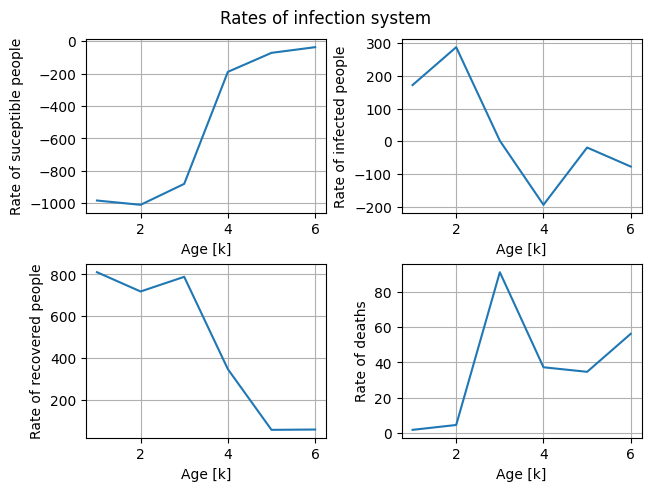

In [68]:
# To plot the rates

dSkdt = -lbd*S*(C@I) - U
dIkdt = lbd*S*(C@I) - (gamr + gamd)*I
dRdt = gamr*I + U
dDdt = gamd*I

k = len(dSkdt)

plot_rates_cont(k, dSkdt, dIkdt, dRdt, dDdt)

In [9]:
def plot_x(S, I, R, D, ranges):
  fig, axs = plt.subplots(2, 2, layout='constrained', figsize = (20,10))
  colors = ['b', 'r', 'g', 'y', 'black', 'magenta']

  for i, age in enumerate(ranges):
    axs[0, 0].plot(S[:,i], colors[i], label = age)
    axs[0, 0].grid(True)
    axs[0, 0].set_title('Evolution of Suceptible')
    axs[0, 0].set_xlabel("Time [days]")
    axs[0, 0].set_ylabel("People [un]")
    axs[0, 0].legend()

    axs[0, 1].plot(I[:,i], colors[i], label = age)
    axs[0, 1].grid(True)
    axs[0, 1].set_title('Evolution of Infected')
    axs[0, 1].set_xlabel("Time [days]")
    axs[0, 1].set_ylabel("People [un]")
    axs[0, 1].legend()

    axs[1, 0].plot(R[:,i], colors[i], label = age)
    axs[1, 0].grid(True)
    axs[1, 0].set_title('Evolution of Recovered')
    axs[1, 0].set_xlabel("Time [days]")
    axs[1, 0].set_ylabel("People [un]")
    axs[1, 0].legend()

    axs[1, 1].plot(D[:,i], colors[i], label = age)
    axs[1, 1].grid(True)
    axs[1, 1].set_title('Evolution of Deaths')
    axs[1, 1].set_xlabel("Time [days]")
    axs[1, 1].set_ylabel("People [un]")
    axs[1, 1].legend()

  plt.suptitle('Evolution of the system through time')
  plt.show()

In [10]:
def plot_x2(S, I, R, D, ranges):
  fig, axs = plt.subplots(2, 2, layout='constrained', figsize = (20,10))
  colors = ['b', 'r', 'g', 'y', 'black', 'magenta']

  for i, age in enumerate(ranges):
    axs[0, 0].plot(S[:,i], colors[i], label = age)
    axs[0, 0].grid(True)
    axs[0, 0].set_title('Evolution of Suceptible')
    axs[0, 0].set_xlabel("Time [hours]")
    axs[0, 0].set_ylabel("People [un]")
    axs[0, 0].legend()

    axs[0, 1].plot(I[:,i], colors[i], label = age)
    axs[0, 1].grid(True)
    axs[0, 1].set_title('Evolution of Infected')
    axs[0, 1].set_xlabel("Time [hours]")
    axs[0, 1].set_ylabel("People [un]")
    axs[0, 1].legend()

    axs[1, 0].plot(R[:,i], colors[i], label = age)
    axs[1, 0].grid(True)
    axs[1, 0].set_title('Evolution of Recovered')
    axs[1, 0].set_xlabel("Time [hours]")
    axs[1, 0].set_ylabel("People [un]")
    axs[1, 0].legend()

    axs[1, 1].plot(D[:,i], colors[i], label = age)
    axs[1, 1].grid(True)
    axs[1, 1].set_title('Evolution of Deaths')
    axs[1, 1].set_xlabel("Time [hours]")
    axs[1, 1].set_ylabel("People [un]")
    axs[1, 1].legend()

  plt.suptitle('Evolution of the system through time')
  plt.show()

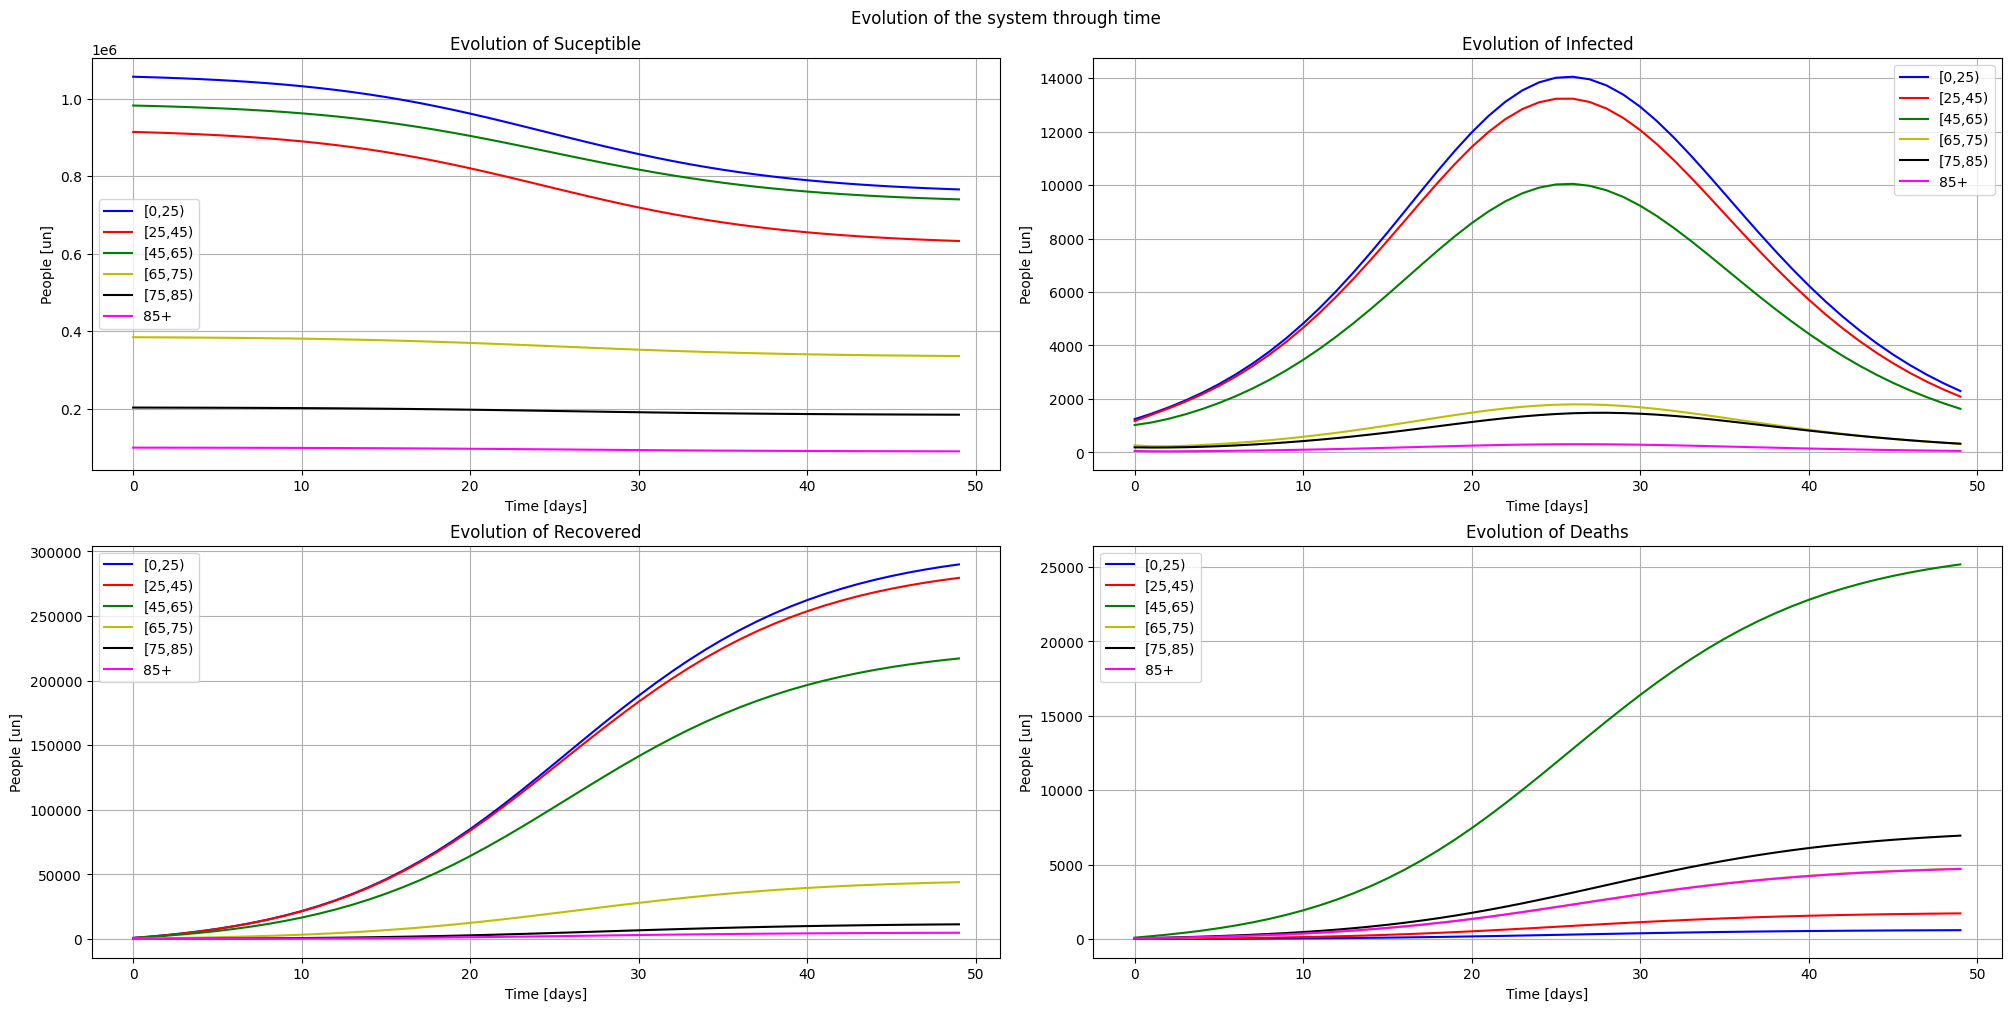

In [72]:
y0 = np.concatenate([S, I, R, D])
x = y0
U = np.array([0,0,0,
              0,0,0]) # For a first step, I can use the U = 0 to test the system
days = 50
S_array = np.zeros(days*6).reshape(days,6)
I_array = np.zeros(days*6).reshape(days,6)
R_array = np.zeros(days*6).reshape(days,6)
D_array = np.zeros(days*6).reshape(days,6)


for day in range(days):
  x = odeint(dxdt, x, [0,1], args=(C, U, gamr, gamd, lbd))
  x = x[1]
  S_array[day] = x[:6]
  I_array[day] = x[6:12]
  R_array[day] = x[12:18]
  D_array[day] = x[18:24]

plot_x(S_array, I_array, R_array, D_array, ranges)

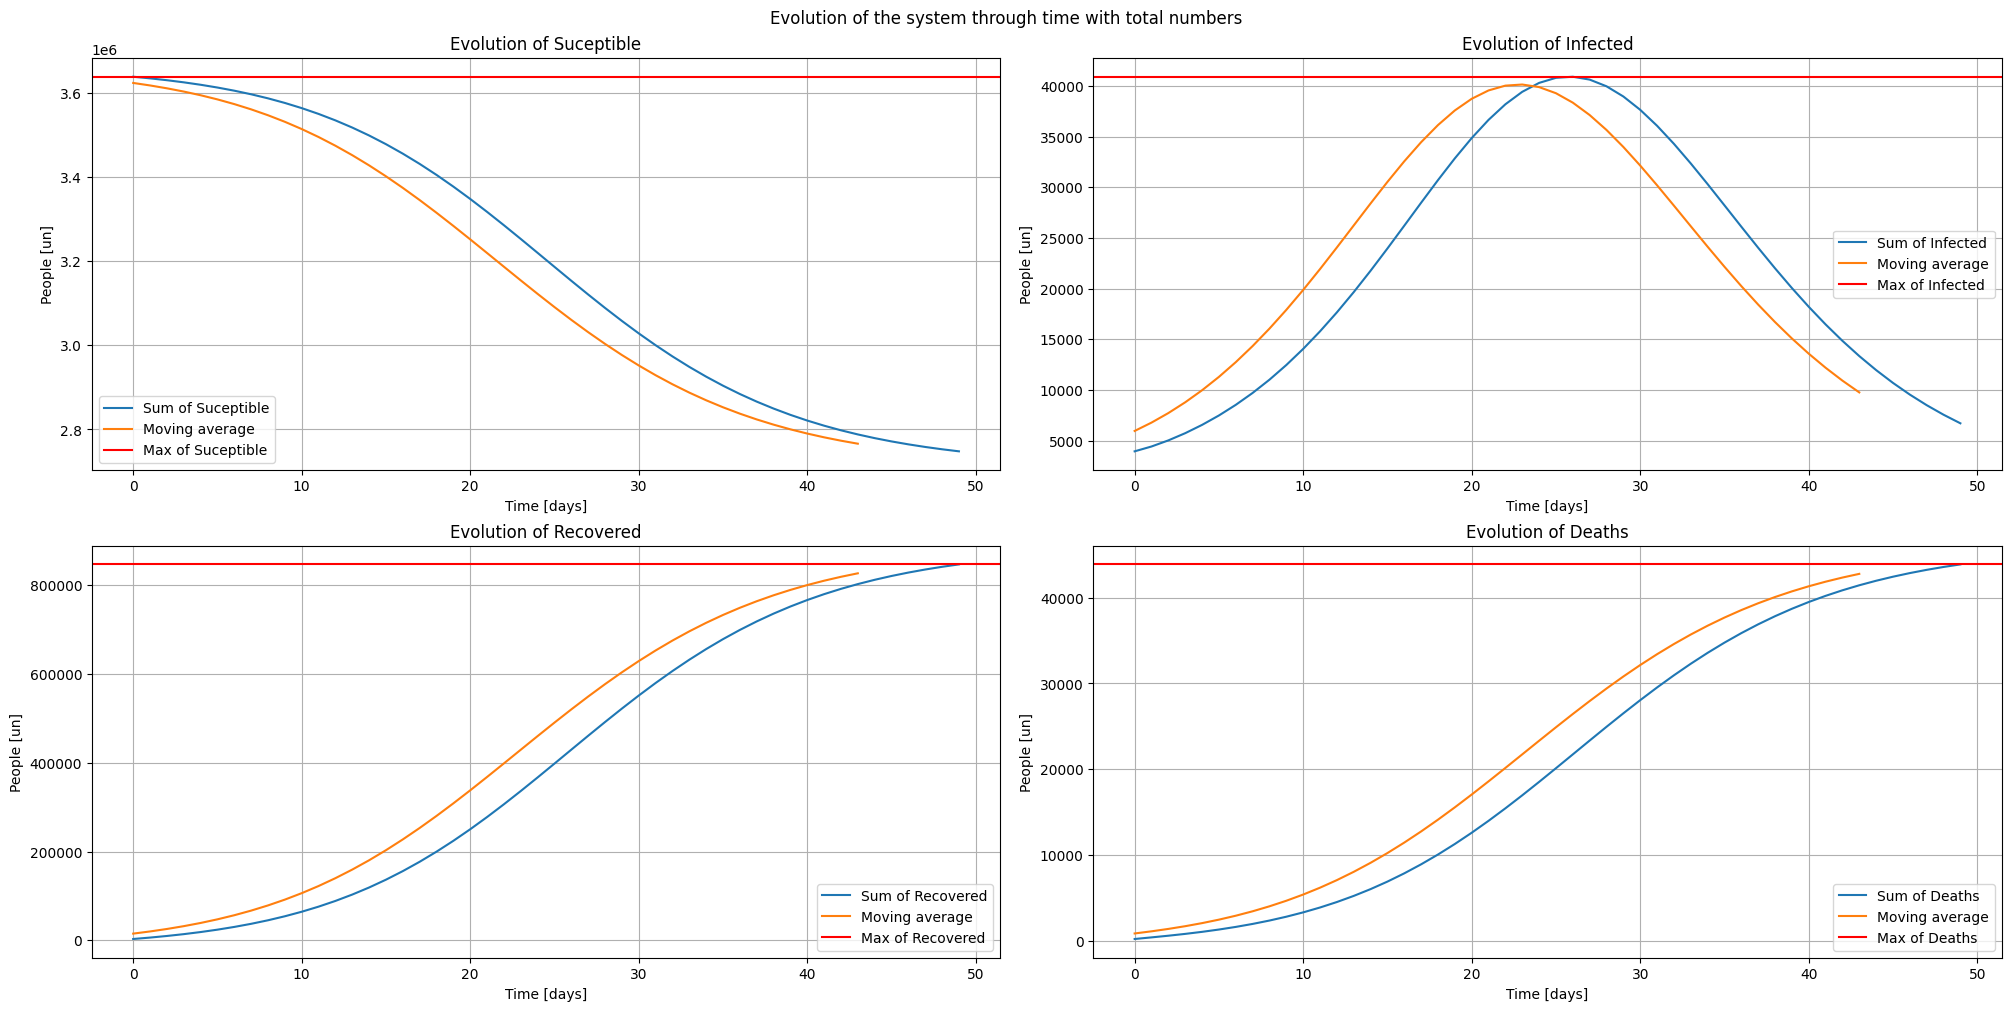

In [56]:
def plot_x_moving_average(S, I, R, D, window_size = 7):
  fig, axs = plt.subplots(2, 2, layout='constrained', figsize = (20,10))

  #Summing the values of the different age classess
  S_sum = np.sum(S, axis=1)
  I_sum = np.sum(I, axis=1)
  R_sum = np.sum(R, axis=1)
  D_sum = np.sum(D, axis=1)

  # Create the moving average array using numpy.convolve
  S_ma = np.convolve(S_sum, np.ones(window_size)/window_size, mode='valid')
  I_ma = np.convolve(I_sum, np.ones(window_size)/window_size, mode='valid')
  R_ma = np.convolve(R_sum, np.ones(window_size)/window_size, mode='valid')
  D_ma = np.convolve(D_sum, np.ones(window_size)/window_size, mode='valid')

  axs[0, 0].plot(S_sum, label = 'Sum of Suceptible')
  axs[0, 0].plot(S_ma, label = 'Moving average')
  axs[0, 0].axhline(y=max(S_sum), color='r', linestyle='-', label = 'Max of Suceptible')
  axs[0, 0].grid(True)
  axs[0, 0].set_title('Evolution of Suceptible')
  axs[0, 0].set_xlabel("Time [days]")
  axs[0, 0].set_ylabel("People [un]")
  axs[0, 0].legend()

  axs[0, 1].plot(I_sum, label = 'Sum of Infected')
  axs[0, 1].plot(I_ma, label = 'Moving average')
  axs[0, 1].axhline(y=max(I_sum), color='r', linestyle='-', label = 'Max of Infected')
  axs[0, 1].grid(True)
  axs[0, 1].set_title('Evolution of Infected')
  axs[0, 1].set_xlabel("Time [days]")
  axs[0, 1].set_ylabel("People [un]")
  axs[0, 1].legend()

  axs[1, 0].plot(R_sum, label = 'Sum of Recovered')
  axs[1, 0].plot(R_ma, label = 'Moving average')
  axs[1, 0].axhline(y=max(R_sum), color='r', linestyle='-', label = 'Max of Recovered')
  axs[1, 0].grid(True)
  axs[1, 0].set_title('Evolution of Recovered')
  axs[1, 0].set_xlabel("Time [days]")
  axs[1, 0].set_ylabel("People [un]")
  axs[1, 0].legend()

  axs[1, 1].plot(D_sum, label = 'Sum of Deaths')
  axs[1, 1].plot(D_ma, label = 'Moving average')
  axs[1, 1].axhline(y=max(D_sum), color='r', linestyle='-', label = 'Max of Deaths')
  axs[1, 1].grid(True)
  axs[1, 1].set_title('Evolution of Deaths')
  axs[1, 1].set_xlabel("Time [days]")
  axs[1, 1].set_ylabel("People [un]")
  axs[1, 1].legend()

  plt.suptitle('Evolution of the system through time with total numbers')
  plt.show()

plot_x_moving_average(S_array, I_array, R_array, D_array)

## 3.2.i -  supposing that the vaccination takes place in continuous time, along the whole day. This would mean to determine U(t) for t ∈ R and apply it to (1), that is then a function of the time. The continuous-time model is then simulated day by day.


In [12]:
def calculate_u(umax, S, u):
  un=umax
  n = len(U)
  for i in range(n-1,-1,-1):
      if S[i] > 0:
          u[i] = np.minimum(S[i],un)
          un = un - u[i]
  return u

In [13]:
def calculate_u2(umax, S, u):
  un=umax
  n = len(U)

  for i in range(n-1,-1,-1):
      if S[i] > 0:
          u[i] = np.minimum(S[i],un)
          return u

In [14]:
'''
  Function to calculate the x dot function
'''

def dxdt2(x,t,C, gamr, gamd, lbd):

  S=x[:6]
  I=x[6:12]

  umax=55191
  U = np.zeros(6)
  U = calculate_u2(umax, S, U)

  dSkdt = -lbd*S*(C@I) - U
  dIkdt = lbd*S*(C@I) - (gamr + gamd)*I
  dRdt = gamr*I + U
  dDdt = gamd*I

  return np.concatenate([dSkdt, dIkdt, dRdt, dDdt])

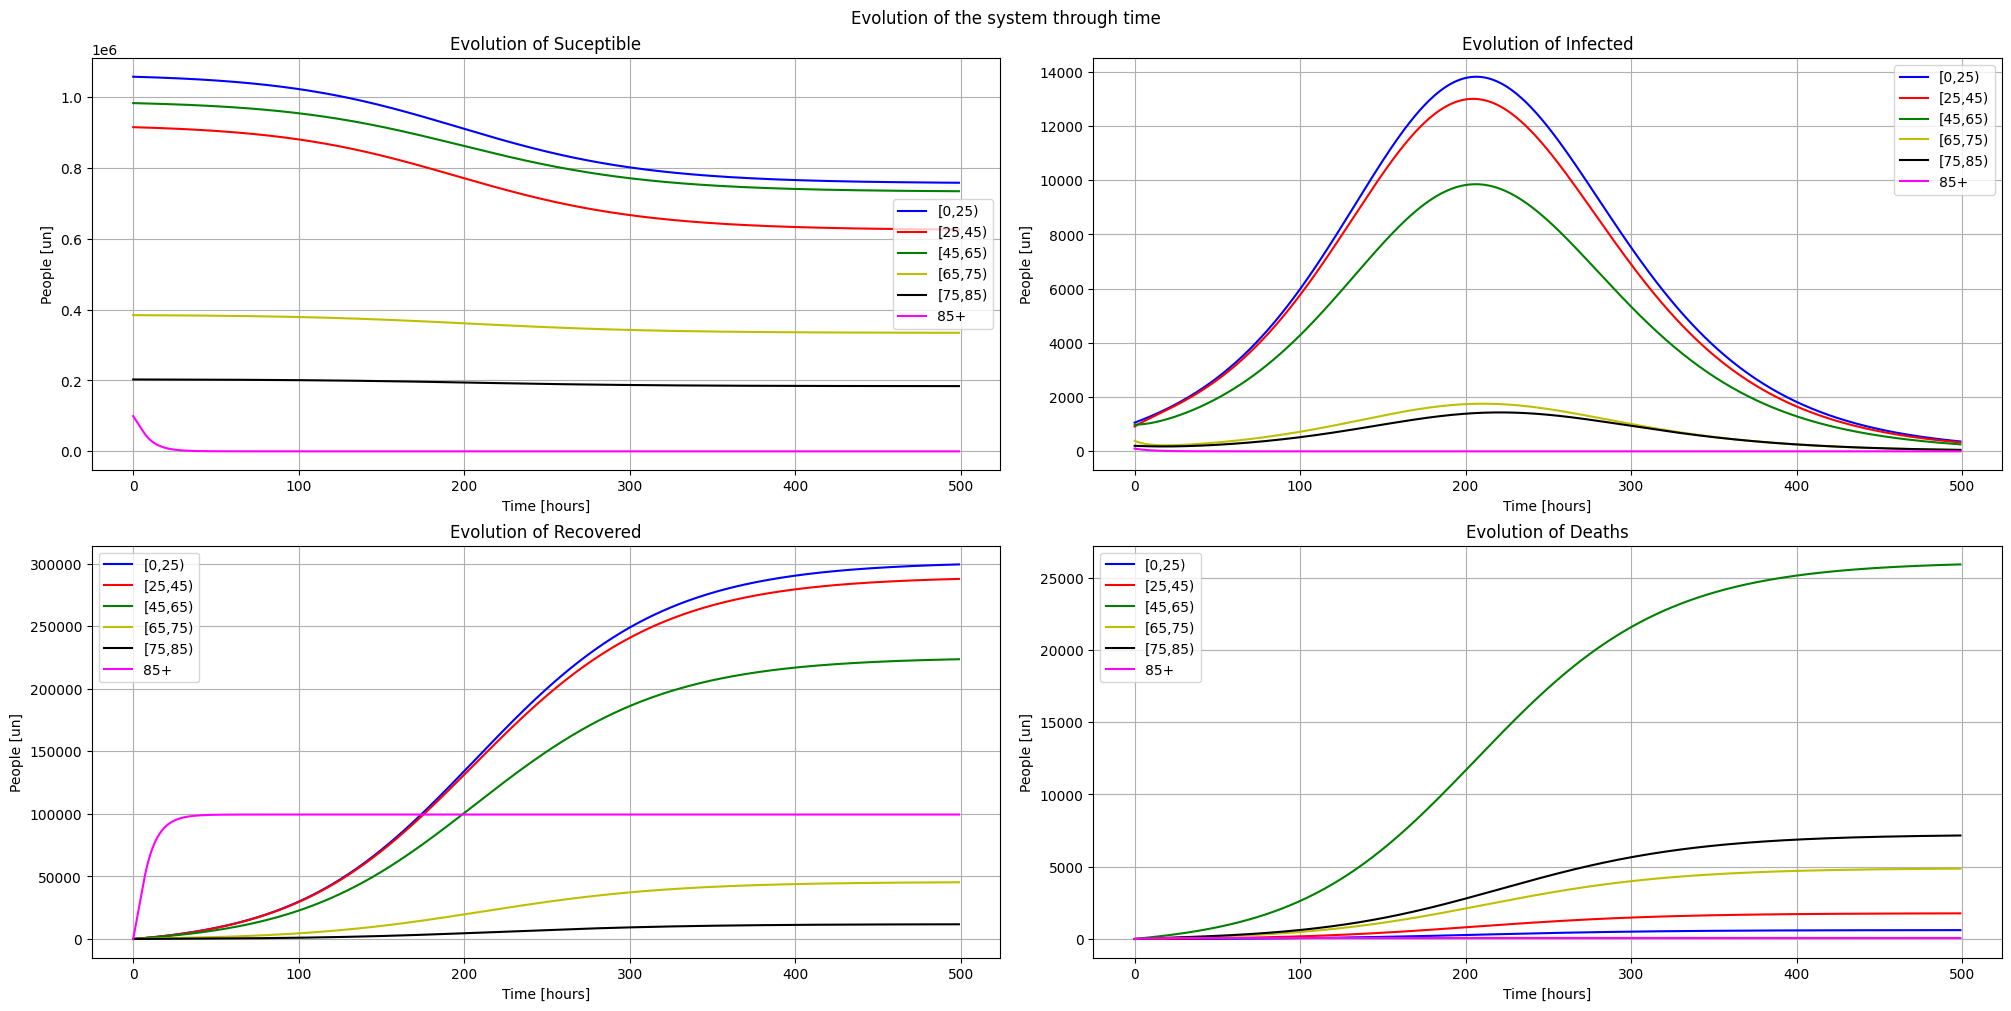

In [15]:
y0 = np.concatenate([S, I, R, D])
x = y0
days = 65

x = odeint(dxdt2, x, np.linspace(0,days, 500), args=(C, gamr, gamd, lbd))

S_array = x[:, :6]
I_array = x[:, 6:12]
R_array = x[:, 12:18]
D_array = x[:, 18:24]

plot_x2(S_array, I_array, R_array, D_array, ranges)

## 3.2.ii - suppose that the whole admissible amount of daily vaccinations Umax is administered instantaneously at the beginning of every day. An appropriate value of Uk(n) is computed for all k-th age range with k = 1, . . . , na such that their summation is equal to Umax and the older susceptible individuals are vaccinated first. After the instantaneous update of the number of susceptibles and recovered, the system (1) is simulated in open loop till the following day.

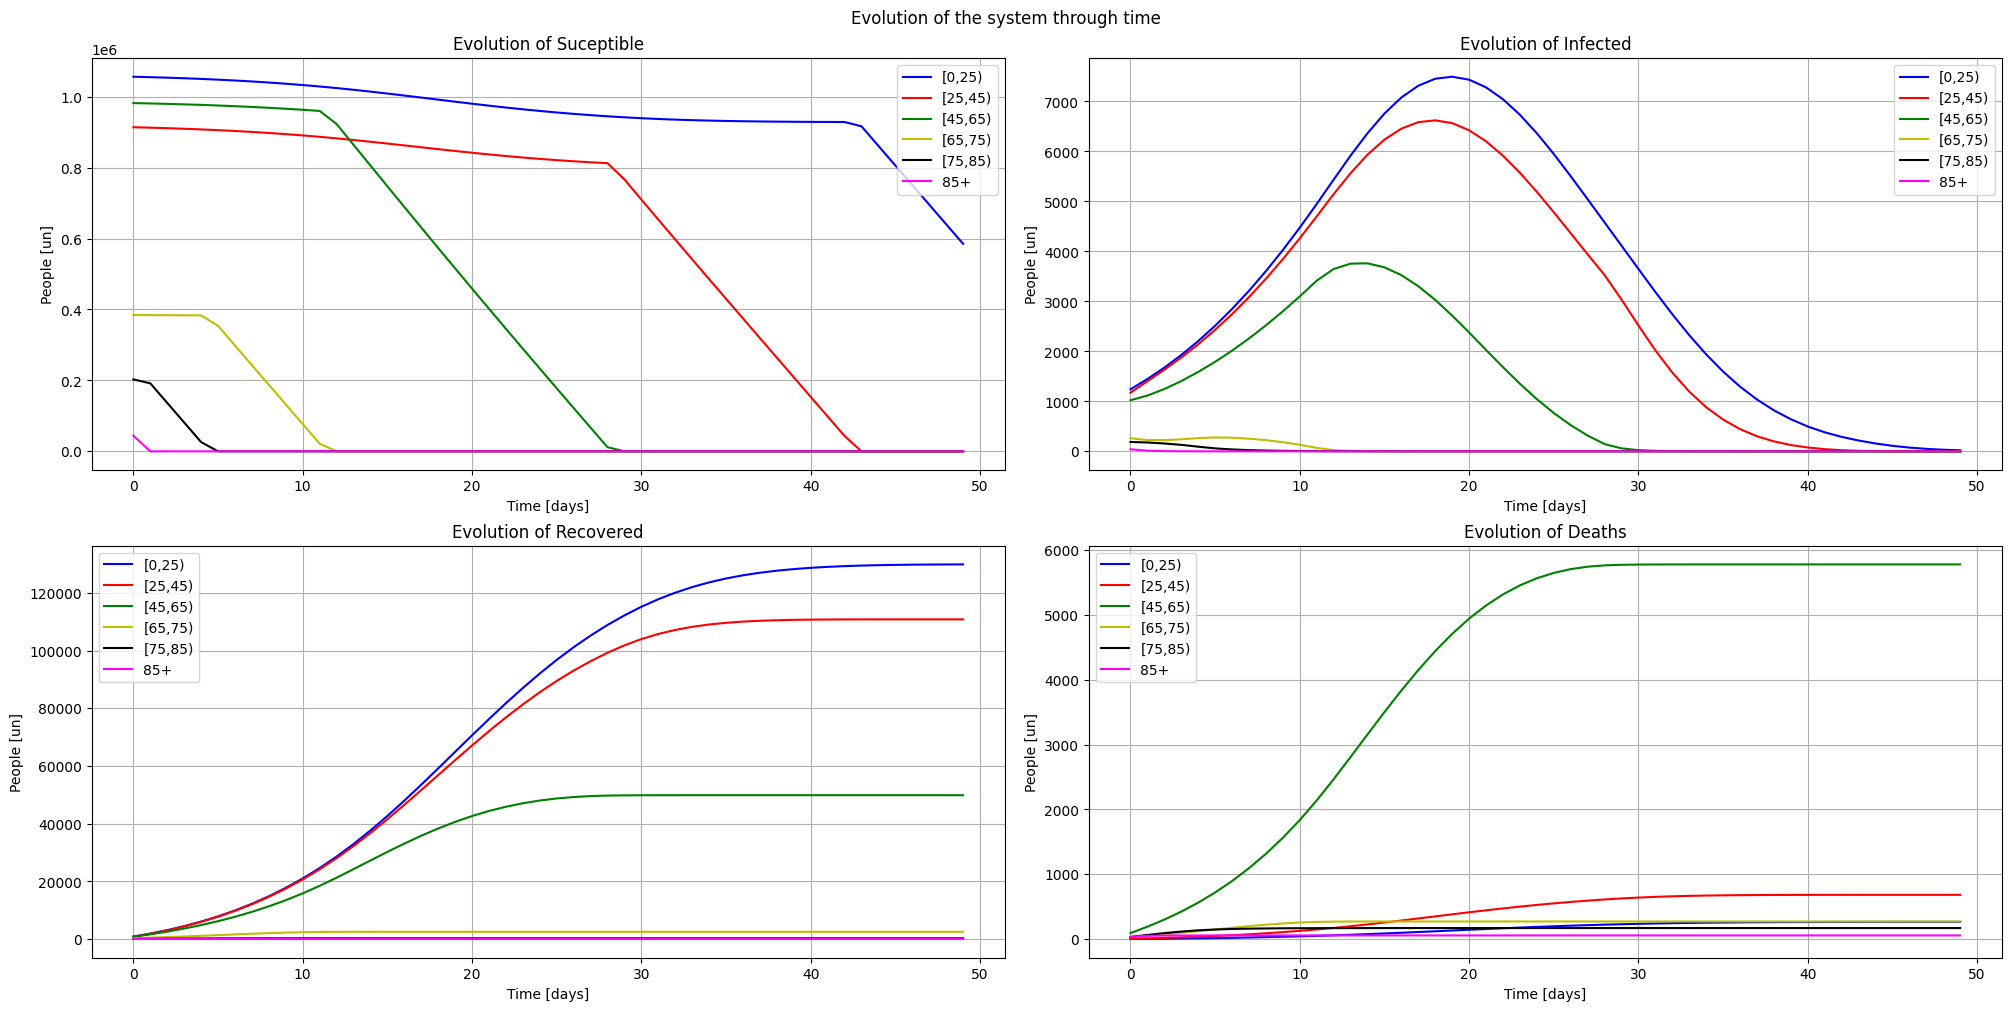

In [73]:
y0 = np.concatenate([S, I, R, D])
x = y0
days = 50
divisions = len(ranges)

S_array = np.zeros(days * divisions).reshape(days,6)
I_array = np.zeros(days * divisions).reshape(days,6)
R_array = np.zeros(days * divisions).reshape(days,6)
D_array = np.zeros(days * divisions).reshape(days,6)


for day in range(days):
  Sk = x[:6]
  U = np.zeros(6)
  U = calculate_u(umax, Sk, U)
  x[:6] = x[:6] - U
  x = odeint(dxdt, x, [0,1], args=(C, 0, gamr, gamd, lbd))
  x = x[1]
  S_array[day] = x[:6]
  I_array[day] = x[6:12]
  R_array[day] = x[12:18]
  D_array[day] = x[18:24]

plot_x(S_array, I_array, R_array, D_array, ranges)

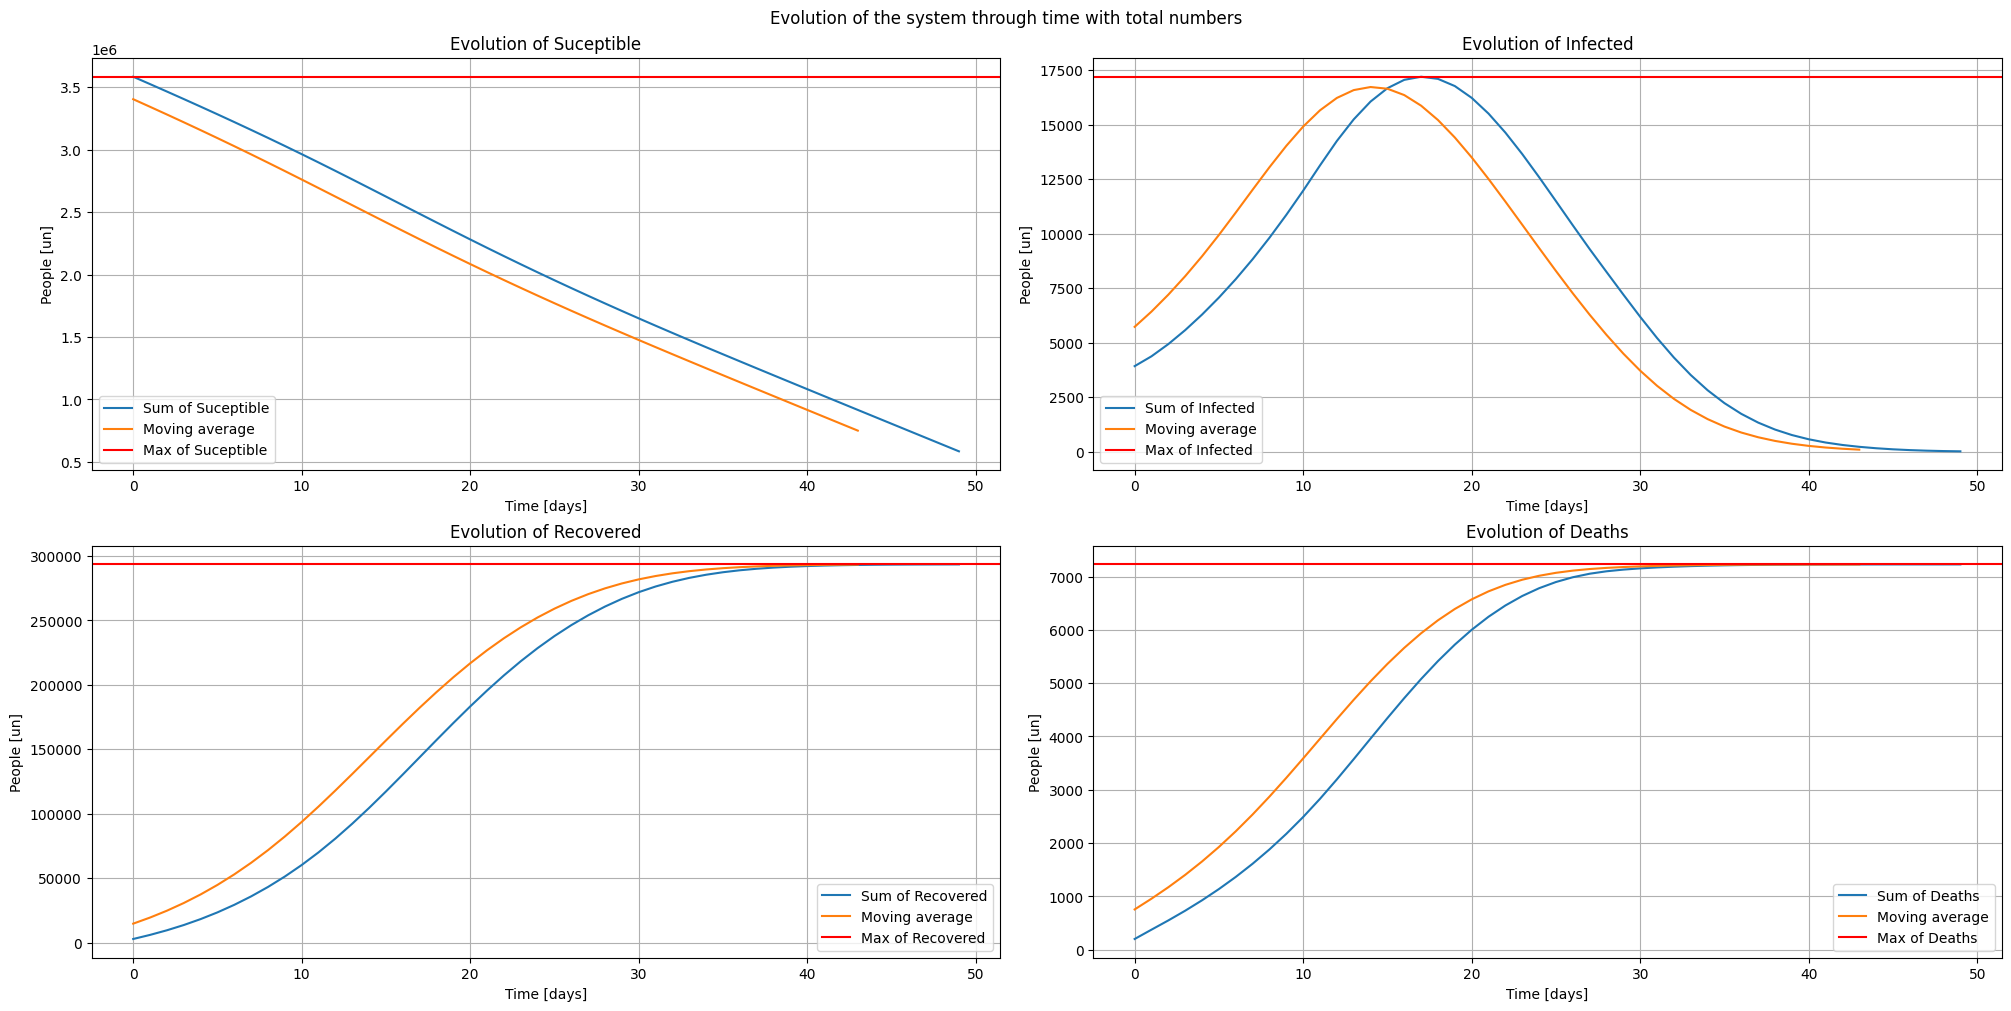

In [74]:
plot_x_moving_average(S_array, I_array, R_array, D_array)

## 3.3 -  implement the discrete-time model (2), with the vaccination input determined as in point (ii) and compare the trajectory with those of the point 2).


In [17]:
def plot_discrete(S, I, R, D, ranges):
  fig, axs = plt.subplots(2, 2, layout='constrained', figsize = (20,10))
  colors = ['b', 'r', 'g', 'y', 'black', 'magenta']

  for i, age in enumerate(ranges):
    axs[0, 0].stem(S[:,i], colors[i], label = age)
    axs[0, 0].grid(True)
    axs[0, 0].set_title('Evolution of Suceptible')
    axs[0, 0].set_xlabel("Time [days]")
    axs[0, 0].set_ylabel("People [un]")
    axs[0, 0].legend()

    axs[0, 1].stem(I[:,i], colors[i], label = age)
    axs[0, 1].grid(True)
    axs[0, 1].set_title('Evolution of Infected')
    axs[0, 1].set_xlabel("Time [days]")
    axs[0, 1].set_ylabel("People [un]")
    axs[0, 1].legend()

    axs[1, 0].stem(R[:,i], colors[i], label = age)
    axs[1, 0].grid(True)
    axs[1, 0].set_title('Evolution of Recovered')
    axs[1, 0].set_xlabel("Time [days]")
    axs[1, 0].set_ylabel("People [un]")
    axs[1, 0].legend()

    axs[1, 1].stem(D[:,i], colors[i], label = age)
    axs[1, 1].grid(True)
    axs[1, 1].set_title('Evolution of Deaths')
    axs[1, 1].set_xlabel("Time [days]")
    axs[1, 1].set_ylabel("People [un]")
    axs[1, 1].legend()

  plt.suptitle('Evolution of the system through time')
  plt.show()

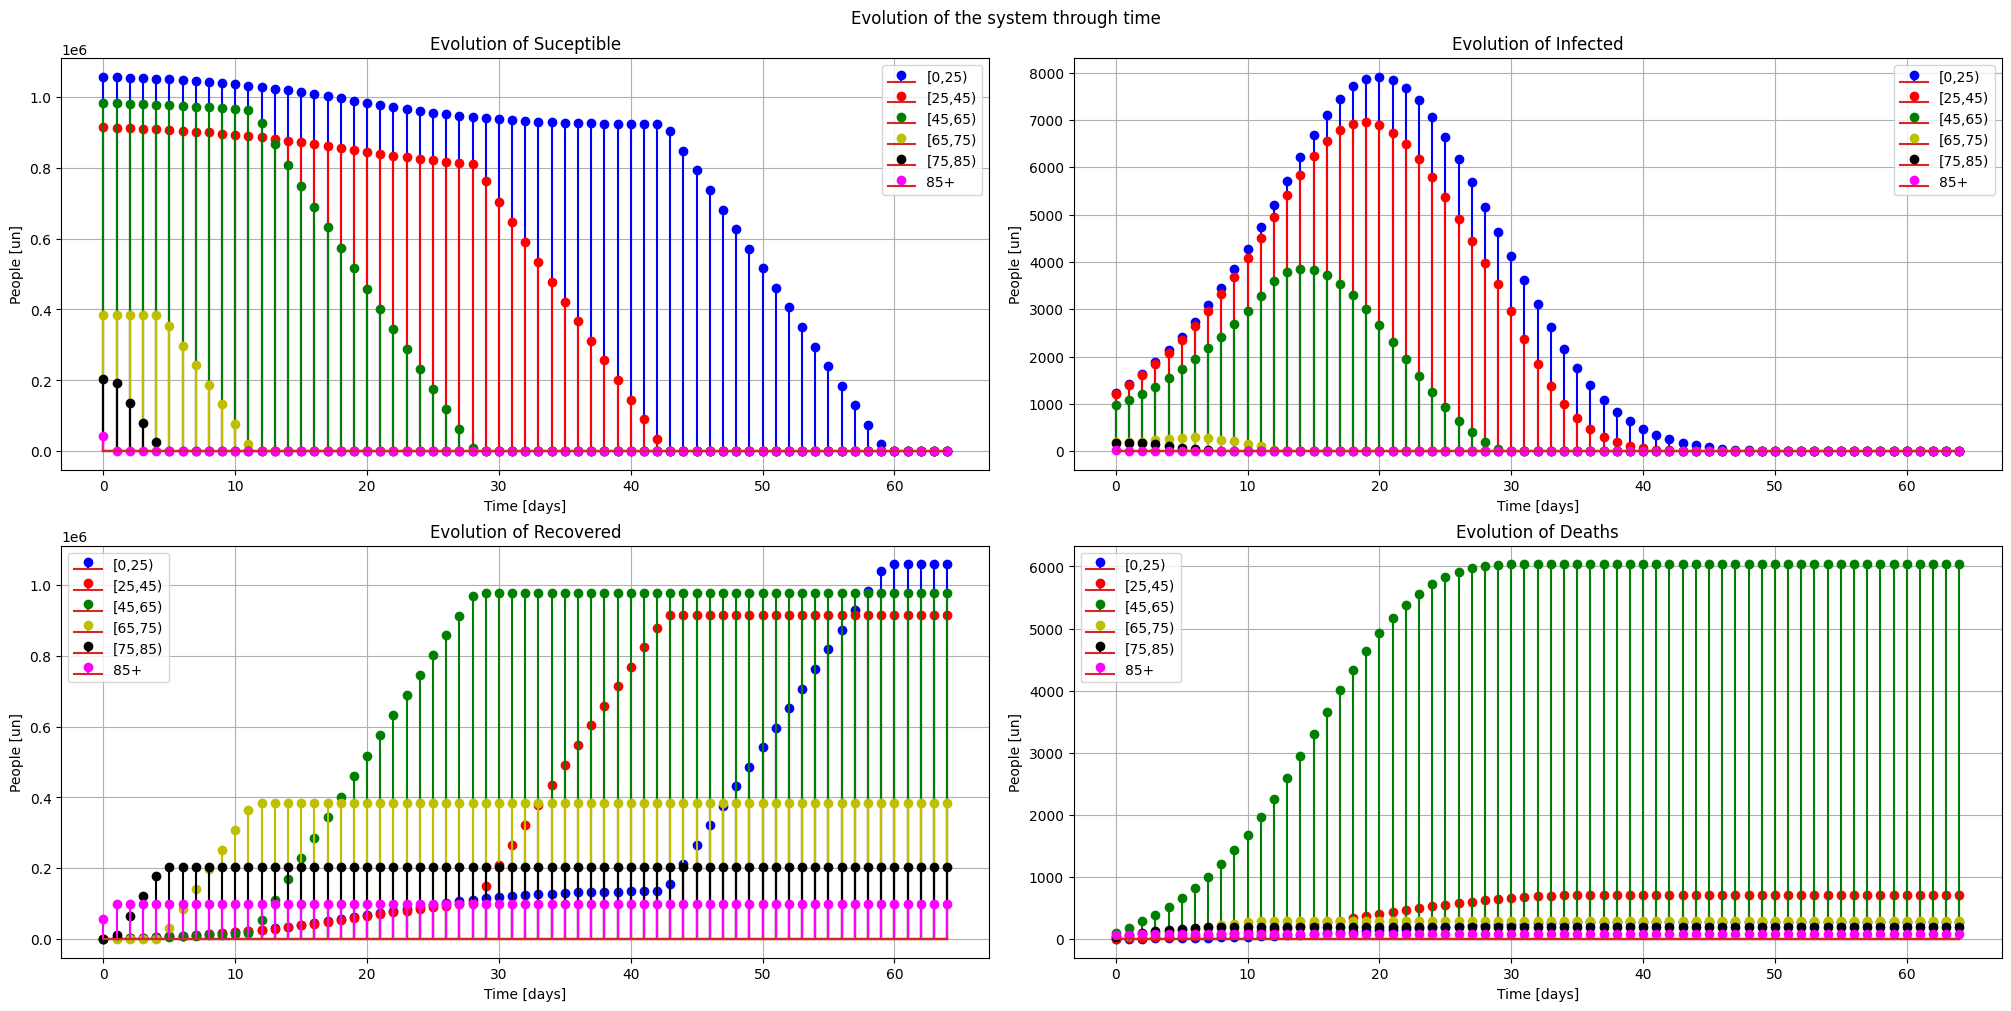

In [18]:
y0 = np.concatenate([S, I, R, D])
x = y0
days = 65
divisions = len(ranges)

S_array_discrete = np.zeros(days * divisions).reshape(days,6)
I_array_discrete = np.zeros(days * divisions).reshape(days,6)
R_array_discrete = np.zeros(days * divisions).reshape(days,6)
D_array_discrete = np.zeros(days * divisions).reshape(days,6)


for day in range(days):

  Sk_n = x[:6]
  Ik_n = x[6:12]
  Rk_n = x[12:18]
  Dk_n = x[18:24]

  umax=55191
  Uk = np.zeros(6)
  Uk = calculate_u(umax, Sk_n, Uk)

  Sk_np1 = Sk_n - lbd*Sk_n*(C@Ik_n) - Uk
  Ik_np1 = Ik_n + lbd*Sk_n*(C@Ik_n) - (gamr + gamd)*Ik_n
  Rk_np1 = Rk_n + gamr*Ik_n + Uk
  Dk_np1 = Dk_n + gamd*Ik_n

  x = np.concatenate([Sk_np1, Ik_np1, Rk_np1, Dk_np1])

  S_array_discrete[day] = x[:6]
  I_array_discrete[day] = x[6:12]
  R_array_discrete[day] = x[12:18]
  D_array_discrete[day] = x[18:24]

plot_discrete(S_array_discrete, I_array_discrete, R_array_discrete, D_array_discrete, ranges)

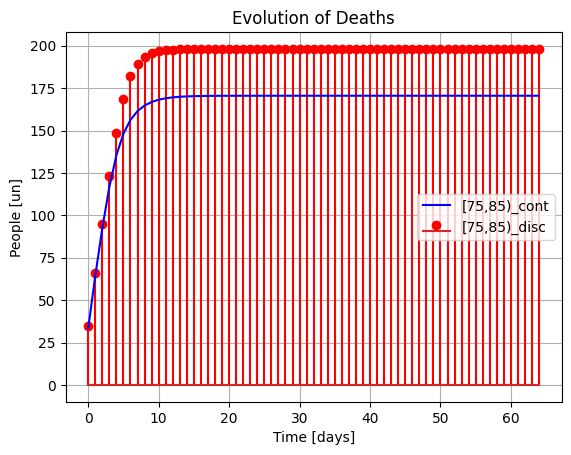

In [19]:

# Comparison between models, example with one range
D_array_discrete

plt.stem(D_array_discrete[:,4], 'r', label = ranges[4] + '_disc')
plt.plot(D_array[:,4], 'b', label = ranges[4] + '_cont')
plt.grid(True)
plt.title('Evolution of Deaths')
plt.xlabel("Time [days]")
plt.ylabel("People [un]")
plt.legend()

# TP2


In [20]:
T = 50. # Time horizon
N = 50 # number of control intervals
N_ages = 6
N_var = 4
epsilon = 0.1

# Declare model variables
x = MX.sym('x', N_var*N_ages)
u = MX.sym('u', 6)

# Model equations
xdot = vertcat(x[:6] - lbd*x[:6]*(C@x[6:12]) - u,
               x[6:12] + lbd*x[:6]*(C@x[6:12]) - (gamr + gamd)*x[6:12],
               x[12:18] + gamr*x[6:12] + u,
               x[18:24] + gamd*x[6:12])

# Objective term
L = DM(gamd).T@x[6:12]
#-----------------------------------------------------------------------------------------------------------------------
F = Function('F', [x, u], [xdot, L], ['x0','p'], ['xf','qf'])

In [21]:
# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

# "Lift" initial conditions
Xk = MX.sym('X0', 24)
w += [Xk]
x0 = np.concatenate((S,I,R,D)).tolist()
lbw += x0
ubw += x0
w0 += [0]*24

#-------------------------------------------------------------------
# Formulate the NLP
for k in range(N):
    # New NLP variable for the control
    Uk = MX.sym('U_' + str(k),6)
    w   += [Uk]
    lbw += [0]*6
    ubw += [umax]*6
    w0  += [0]*6

    # Add constraint for Uk
    g   += [np.ones((1,6))@Uk]
    lbg += [0]
    ubg += [umax]

    # Integrate till the end of the interval
    Fk = F(x0=Xk, p=Uk)
    Xk_end = Fk['xf']
    J += DM(gamd).T @ Xk[6:12]

    # New NLP variable for state at end of interval
    Xk = MX.sym('X_' + str(k+1), 24)
    w   += [Xk]
    lbw += [0]*24
    ubw += [inf]*24
    w0  += [0]*24

    # Add equality constraint
    g   += [Xk_end-Xk]
    lbg += [0]*24
    ubg += [0]*24

J += (1/epsilon) * DM(gamd).T @ Xk_end[6:12]

In [22]:
# Create an NLP solver
prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
solver = nlpsol('solver', 'ipopt', prob);

# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
w_opt = sol['x'].full().flatten()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     7092
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:     1764

Total number of variables............................:     1500
                     variables with only lower bounds:     1200
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1200
Total number of inequality c

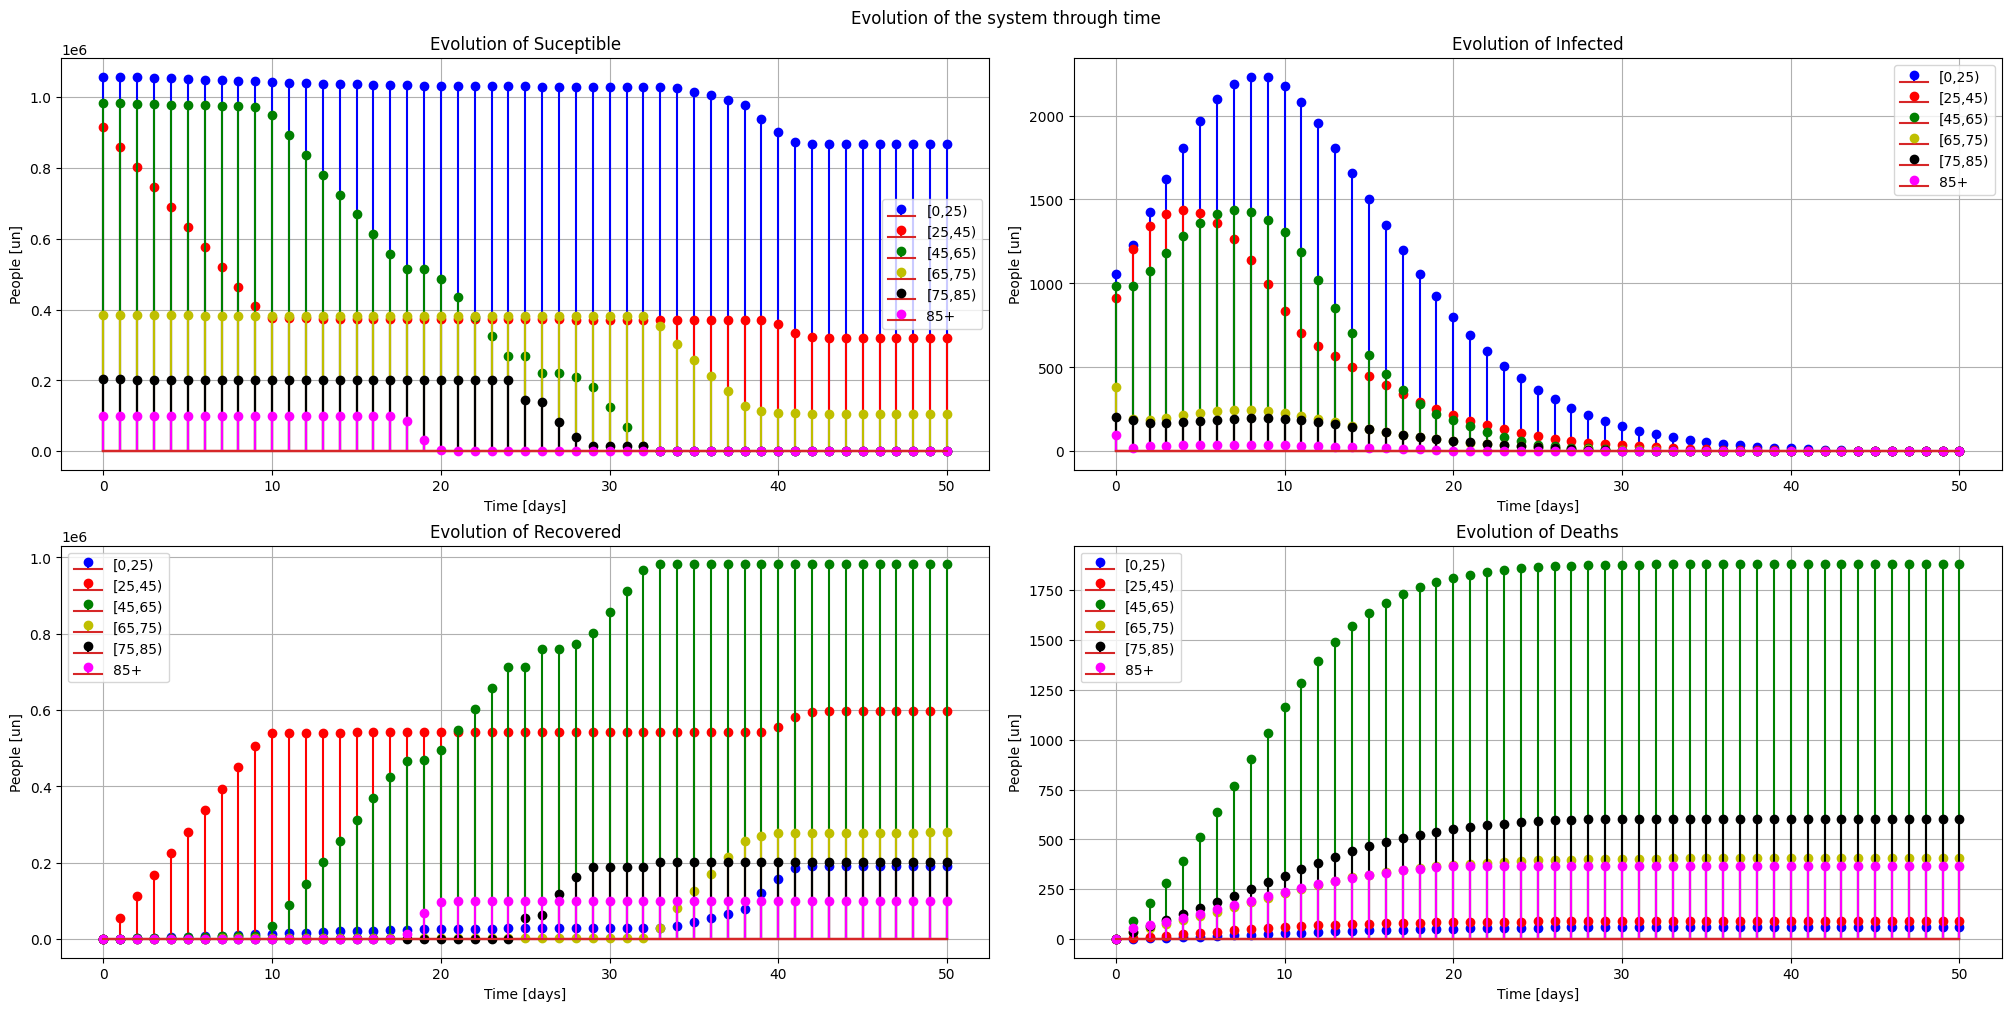

In [23]:
# Plot the solution
x_opt = []
for i in range(N+1):
    x_opt.append(w_opt[i*30:i*30+24])
x_opt = np.array(x_opt)
S_opt = x_opt[:,0:6]
I_opt = x_opt[:,6:12]
R_opt = x_opt[:,12:18]
D_opt = x_opt[:,18:24]

plot_discrete(S_opt, I_opt, R_opt, D_opt, ranges)